## <center> Python Dask
<img src="https://github.com/Ray800413/Spatial_Join_with_Dask/blob/master/image/dask.png?raw=true" style="width: 400px;">

Spatial Join is one of the most common spatial operations in GIS world. We often do spatial join using GIS software, such as ArcGIS and QGIS. Nevertheless, we can also do spatial join easily with Python library `Geopandas`. `Geopandas` works well on mid-scale data, but the performacne degrade when its comes to large-scale data. 

One potential solution is using `Dask`, which will be dicussed later, to enable spatial operations work in parallel. 
While it is unavailable to work directly with `Geopandas` and `Dask`, a smart guy provides an example to use `Dask` in point to polygon spatial join. This jupyter notebook is adapted from his [blogpost](https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8).

Learning `Dask` may be intimidated in the first place, especially if you don't understand the concept of distributed system and parallel computing. In this regard, this tutorial starts with introduction of `Dask` and several examples to help you gain better understanding about it. Next, we will learn how to take advantage of `Dask` to speed up the point in polygon spatial join. Finally, this tutorial provides you with a simple example of using `Geopandas` and **_Spatial Index_** to speed up common spatial operations, such as intersects, within, contains, and so on. 

*Note: This tutorial assumes you are already familiar with Python `Pandas` and `Geopandas` modules.*

### 1. Dask introduction

#### 1.1 TL;NR
`Dask` allows you to process your data in parallel, meaning less time to execute and wait, and more time to do analysis! `Dask` provides three parallel collection, namely **dataframe**, **array**, and **bag**. It also has a **scheduler** to execute your code on parallel hardware. 

#### 1.2 Understand Dask
`Dask` is a tool that helps us easily extend our familiar python data analysis libraries to medium and big data. In many cases, it also allows us to speed up our analysis using multiple CPU cores. It can not only help us work more efficiently on our laptop but also scale up our analysis on HPC and cloud platforms. 

`Dask` provides **three parallel collection for storing big data** and **a scheduler for parallel computing**.
1. **Three Parallel collections**:
    1. `dask.dataframe`: a large parallel Dataframe composed of many smaller `Pandas` DataFrames, split along the index. 
    2. `dask.array`: implementing a subset of the Numpy ndarray interface using blocked algorithms, cutting up the large `Numpy` array into many small arrays. 
    3. `dask.bag`: implementing operations like `map`, `filter`, and `group by` on collections of generic Python objects. 
    
    
2. **Families of Scheduler**:
    1. *Single machine scheduler*: This scheduler provides basic features on a local process or thread pool. It is the defaule scheduler and can only be used on a single machine and does not scale.
    2. *Distributed scheduler*: This scheduler is more sophisticated. It offers more features, but also requires a bit more to set up. It can run locally or distributed across a cluster. 

*Note: According to the `Dask` official document, `dask.distributed` scheduler is often preferable, even on single workstations as it contains many diagnostics and features not found in the older single-machine scheduler.* 
#### 1.3 Dask distributed environment set up

In [1]:
# Set up a dask distributed environment
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:56742 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


- `dask.distributed.LocalCluster`: Create local cluster as many workers as cores
- `dask.distributed.Client`: create a client and connect to local cluster

When you set up the distributed environment, `dask` automatically provides you with a diagnostic dashboard to aid in profiling and inspecting execution with the distributed scheduler. It is helpful to open it on the side to help you better understand how `dask` works. 

### 2. Examples

The dataset we are going to use throughout this tutorial is a historic arrest records in New York City retrieved from [DATA.GOV](https://www.data.gov/). This dataset contains information about perpetrators and coordinates where they were arrested. The size of this dataset is about 350MB. While this size can not be called "big data", it is suitable for using it as a starting point to learn `Dask`.

Since we only work with tabular data, this tutorial only introduces `dask.dataframe`. The biggest differenct between `dask.dataframe` and `pandas.dataframe` is that `Dask` operations are "lazy", which we will discuss later. `Dask` builds up a task graph first and then hand to the scheduler to execute these tasks in parallel.

Without further ado, let's get started. 

#### Example 1: Find the number of female and male perpetrators

In [2]:
# Import modules
import dask.dataframe as dd

In [3]:
# Load the file into dask dataframe
# Dask split the data into six partitions
ddf = dd.read_csv("data/NYC_historic_arrest/NYC_Historic_Arrest_Clean.csv", 
                  parse_dates = ["ARREST_DATE"], 
                  dtype = {"ARREST_PRECINCT": object})
ddf

,ARREST_DATE,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
npartitions=6,,,,,,,,
,datetime64[ns],object,object,object,object,object,float64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


- *Note here I specify the datatype when reading the file. This is because, unlike `Pandas` reads in the entire file before inferring datatypes, `Dask` only reads in a sample from the beginning of the file. These inferred datatypes are then enforced when reading all partitions. Hence, It is recommended using `dtype` to enforce datatype being consistent across the rows.*

Since most `Dask` operations are "lazy", meaning that they do not evaluate until we explicitly ask for a result using the `compute()` method. The `compute()` method returns in-memory results. It converts a `dask.dataframe` to a `pandas.dataframe`. Generally, you should only call `compute()` on results that will fit comfortably in memory. If the result doesn't fit in memory, then you might consider writting it to disk instead, such as using `to_parquet` method. 

In [4]:
# This doesn't cause computation
gender_number = ddf.groupby("PERP_SEX").size()

Before executing computation, we can visualize the underlying task graph using `visualize()` method. By looking at the graph we can learn more about potential bottlenecks where parallelism may not be possible, or areas where many tasks depend on each other, which may cause a great deal of communication.

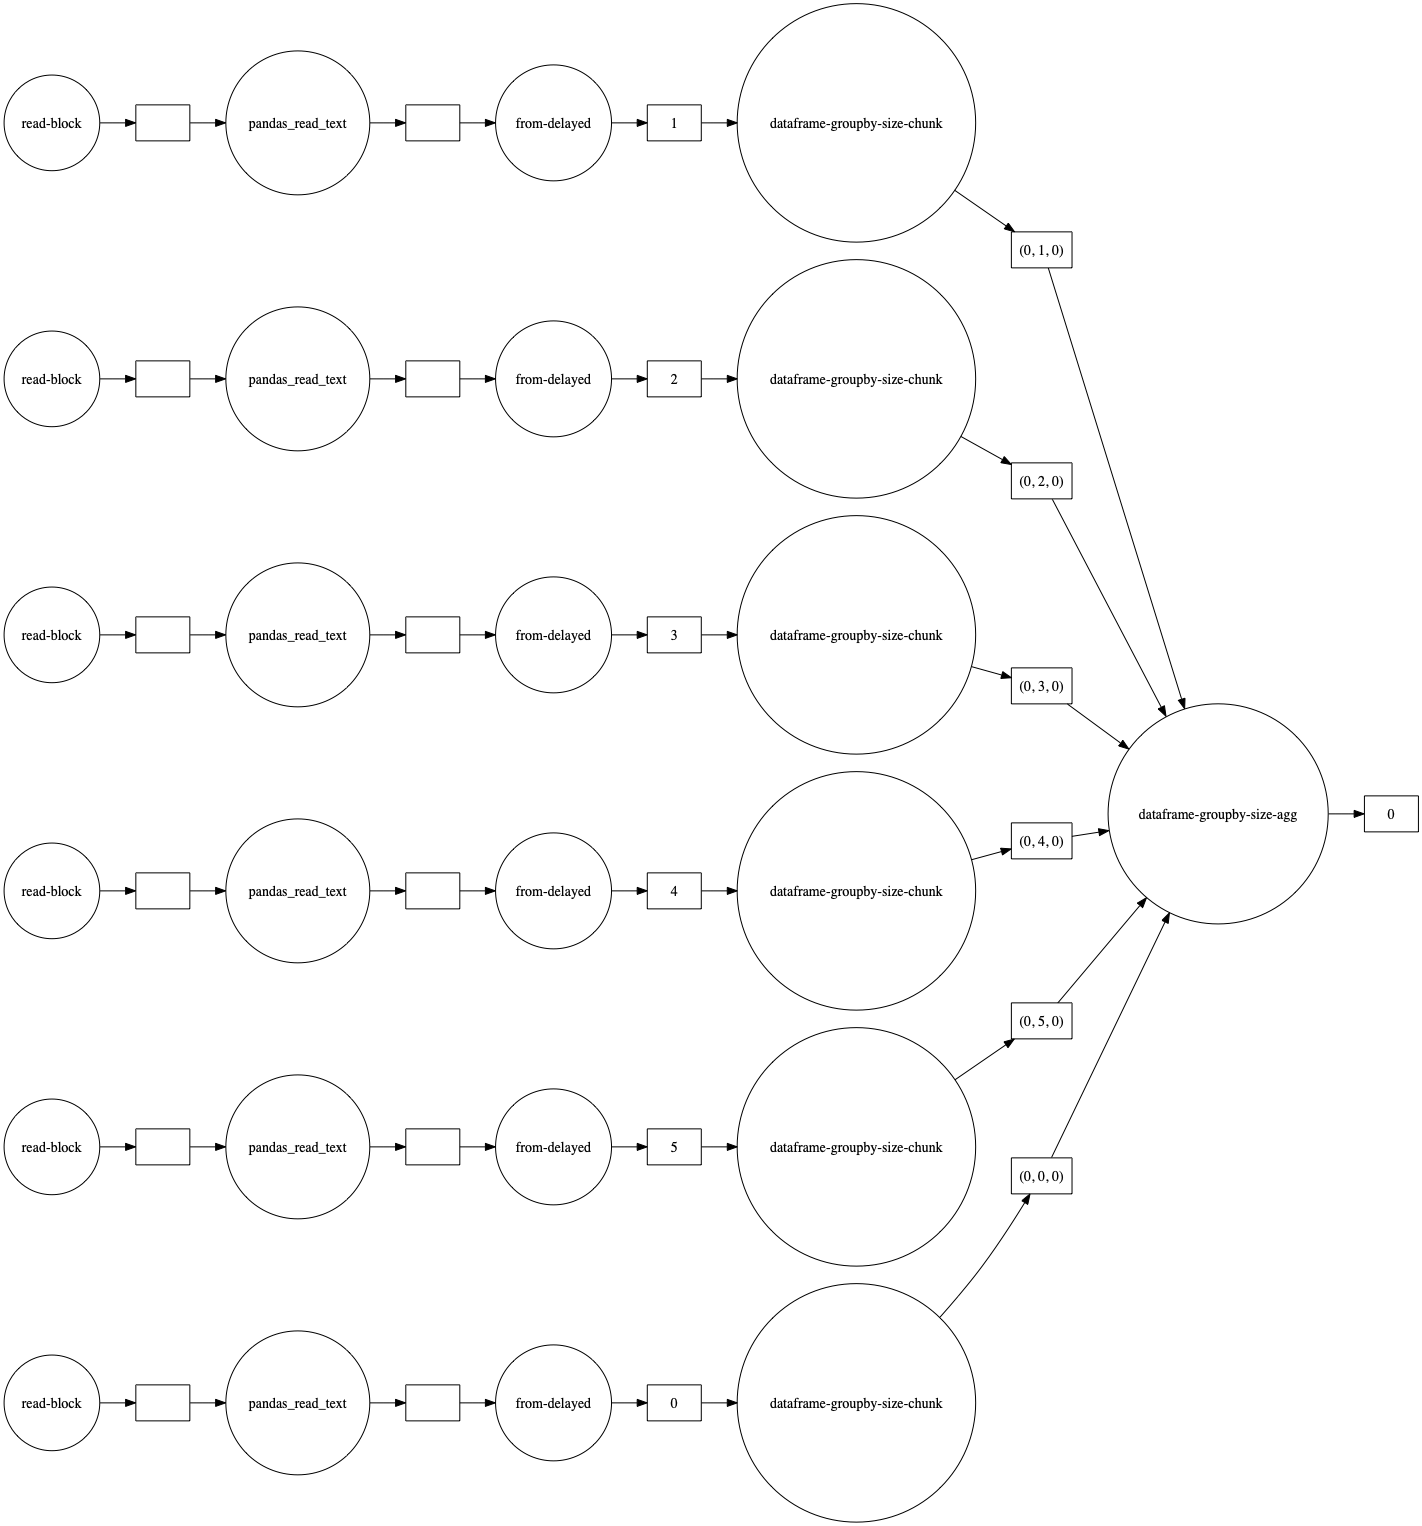

In [5]:
# Visualize the underlying task graph
# The task will be rendered from left to right as the graph shows
gender_number.visualize(rankdir = "LR")

In [6]:
# Trigger computation by explicitly calling the compute() method
gender_number.compute()

PERP_SEX
F     801292
M    3989920
dtype: int64

After running the above code, you can go to the diagnostics dashboard to inspect the execution. You will see something like the image shown below

<img src="https://github.com/Ray800413/Spatial_Join_with_Dask/blob/master/image/dashboard.jpg?raw=true" style="width: 600px;">

#### Example 2: Find the total numbers of arrests in each year

In [7]:
# Group by the year
year = ddf.ARREST_DATE.dt.year
year_count = ddf.groupby(year).size().reset_index().rename(columns = {"ARREST_DATE":"Year", 0: "Total_Count"}).set_index("Year")

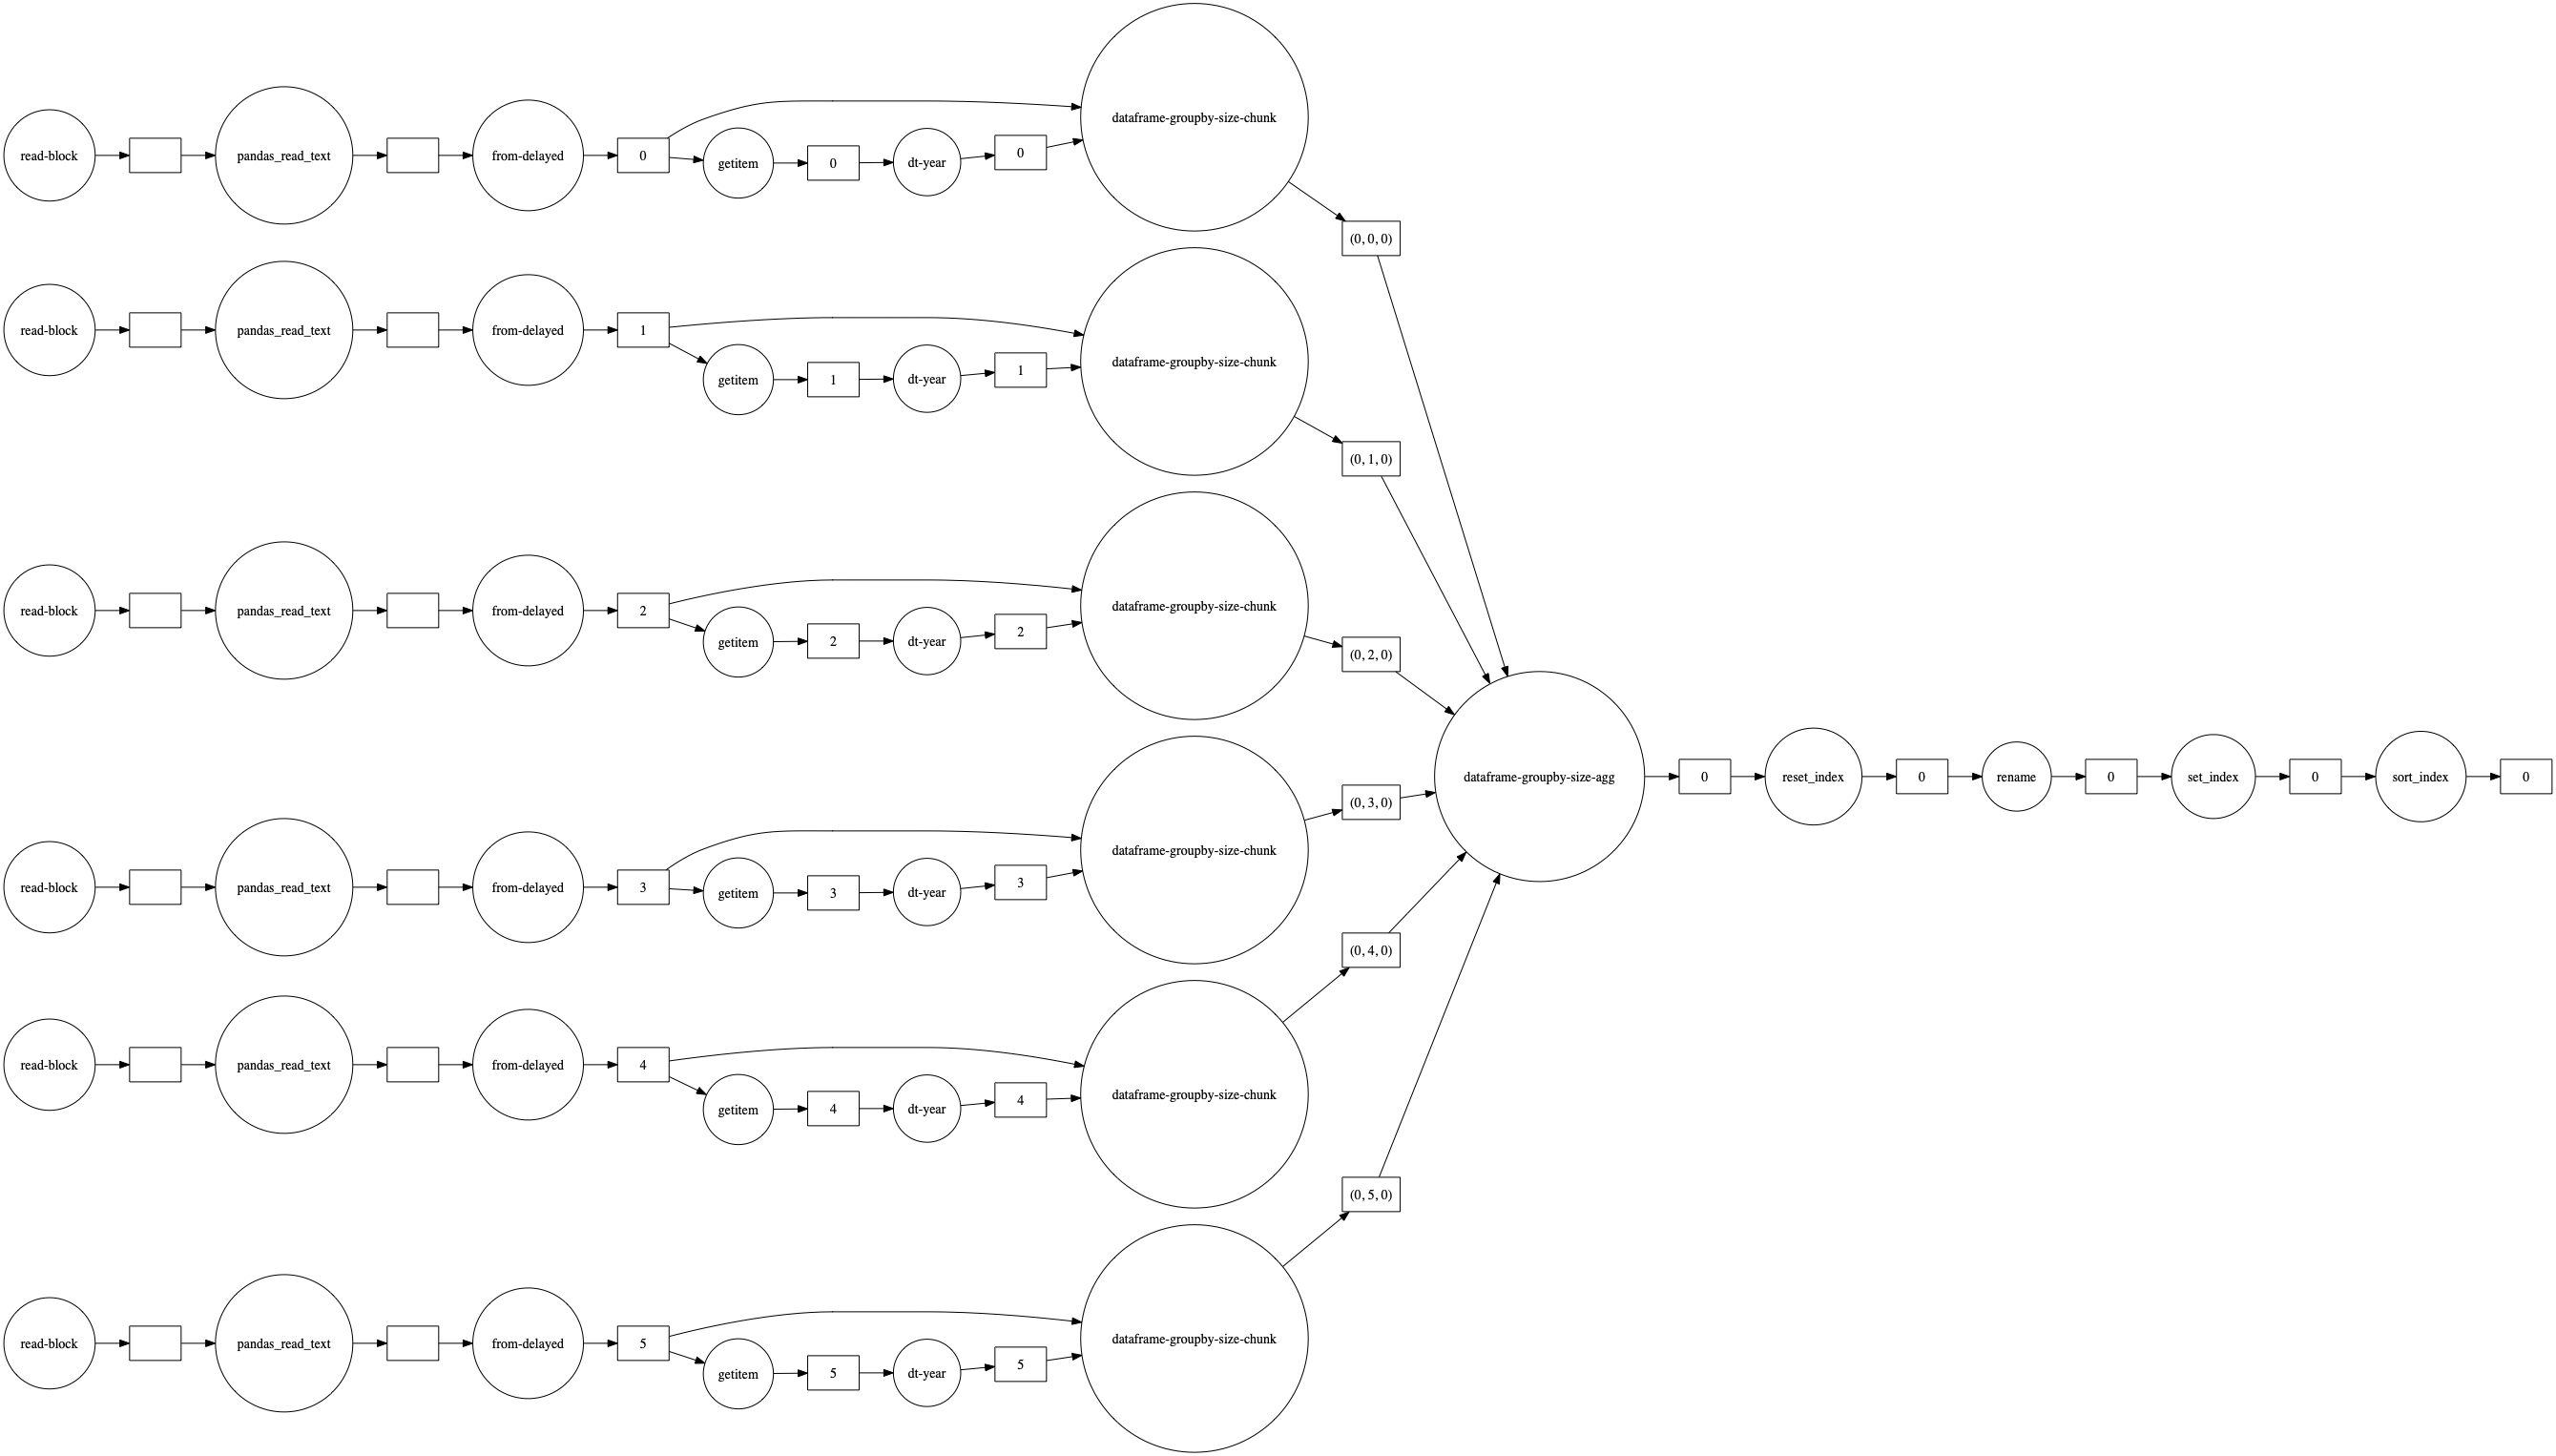

In [8]:
# Visualize the underlying task graph
# The task will be rendered from left to right as the graph shows
year_count.visualize(rankdir = "LR")

In [9]:
# Trigger computation by explicitly calling the compute() method
year_count.compute()

,Total_Count
Year,
2006,371896
2007,403149
2008,401372
2009,420373
2010,419459
2011,410681
2012,395414
2013,393809
2014,387727


#### Example 3: Find which borough has the maximum numbers of arrests

In [10]:
# Groupy by the borough and return the top borough
bor_count = ddf.groupby("ARREST_BORO").size().reset_index().rename(columns = {0:"Count"}).nlargest(1, "Count")

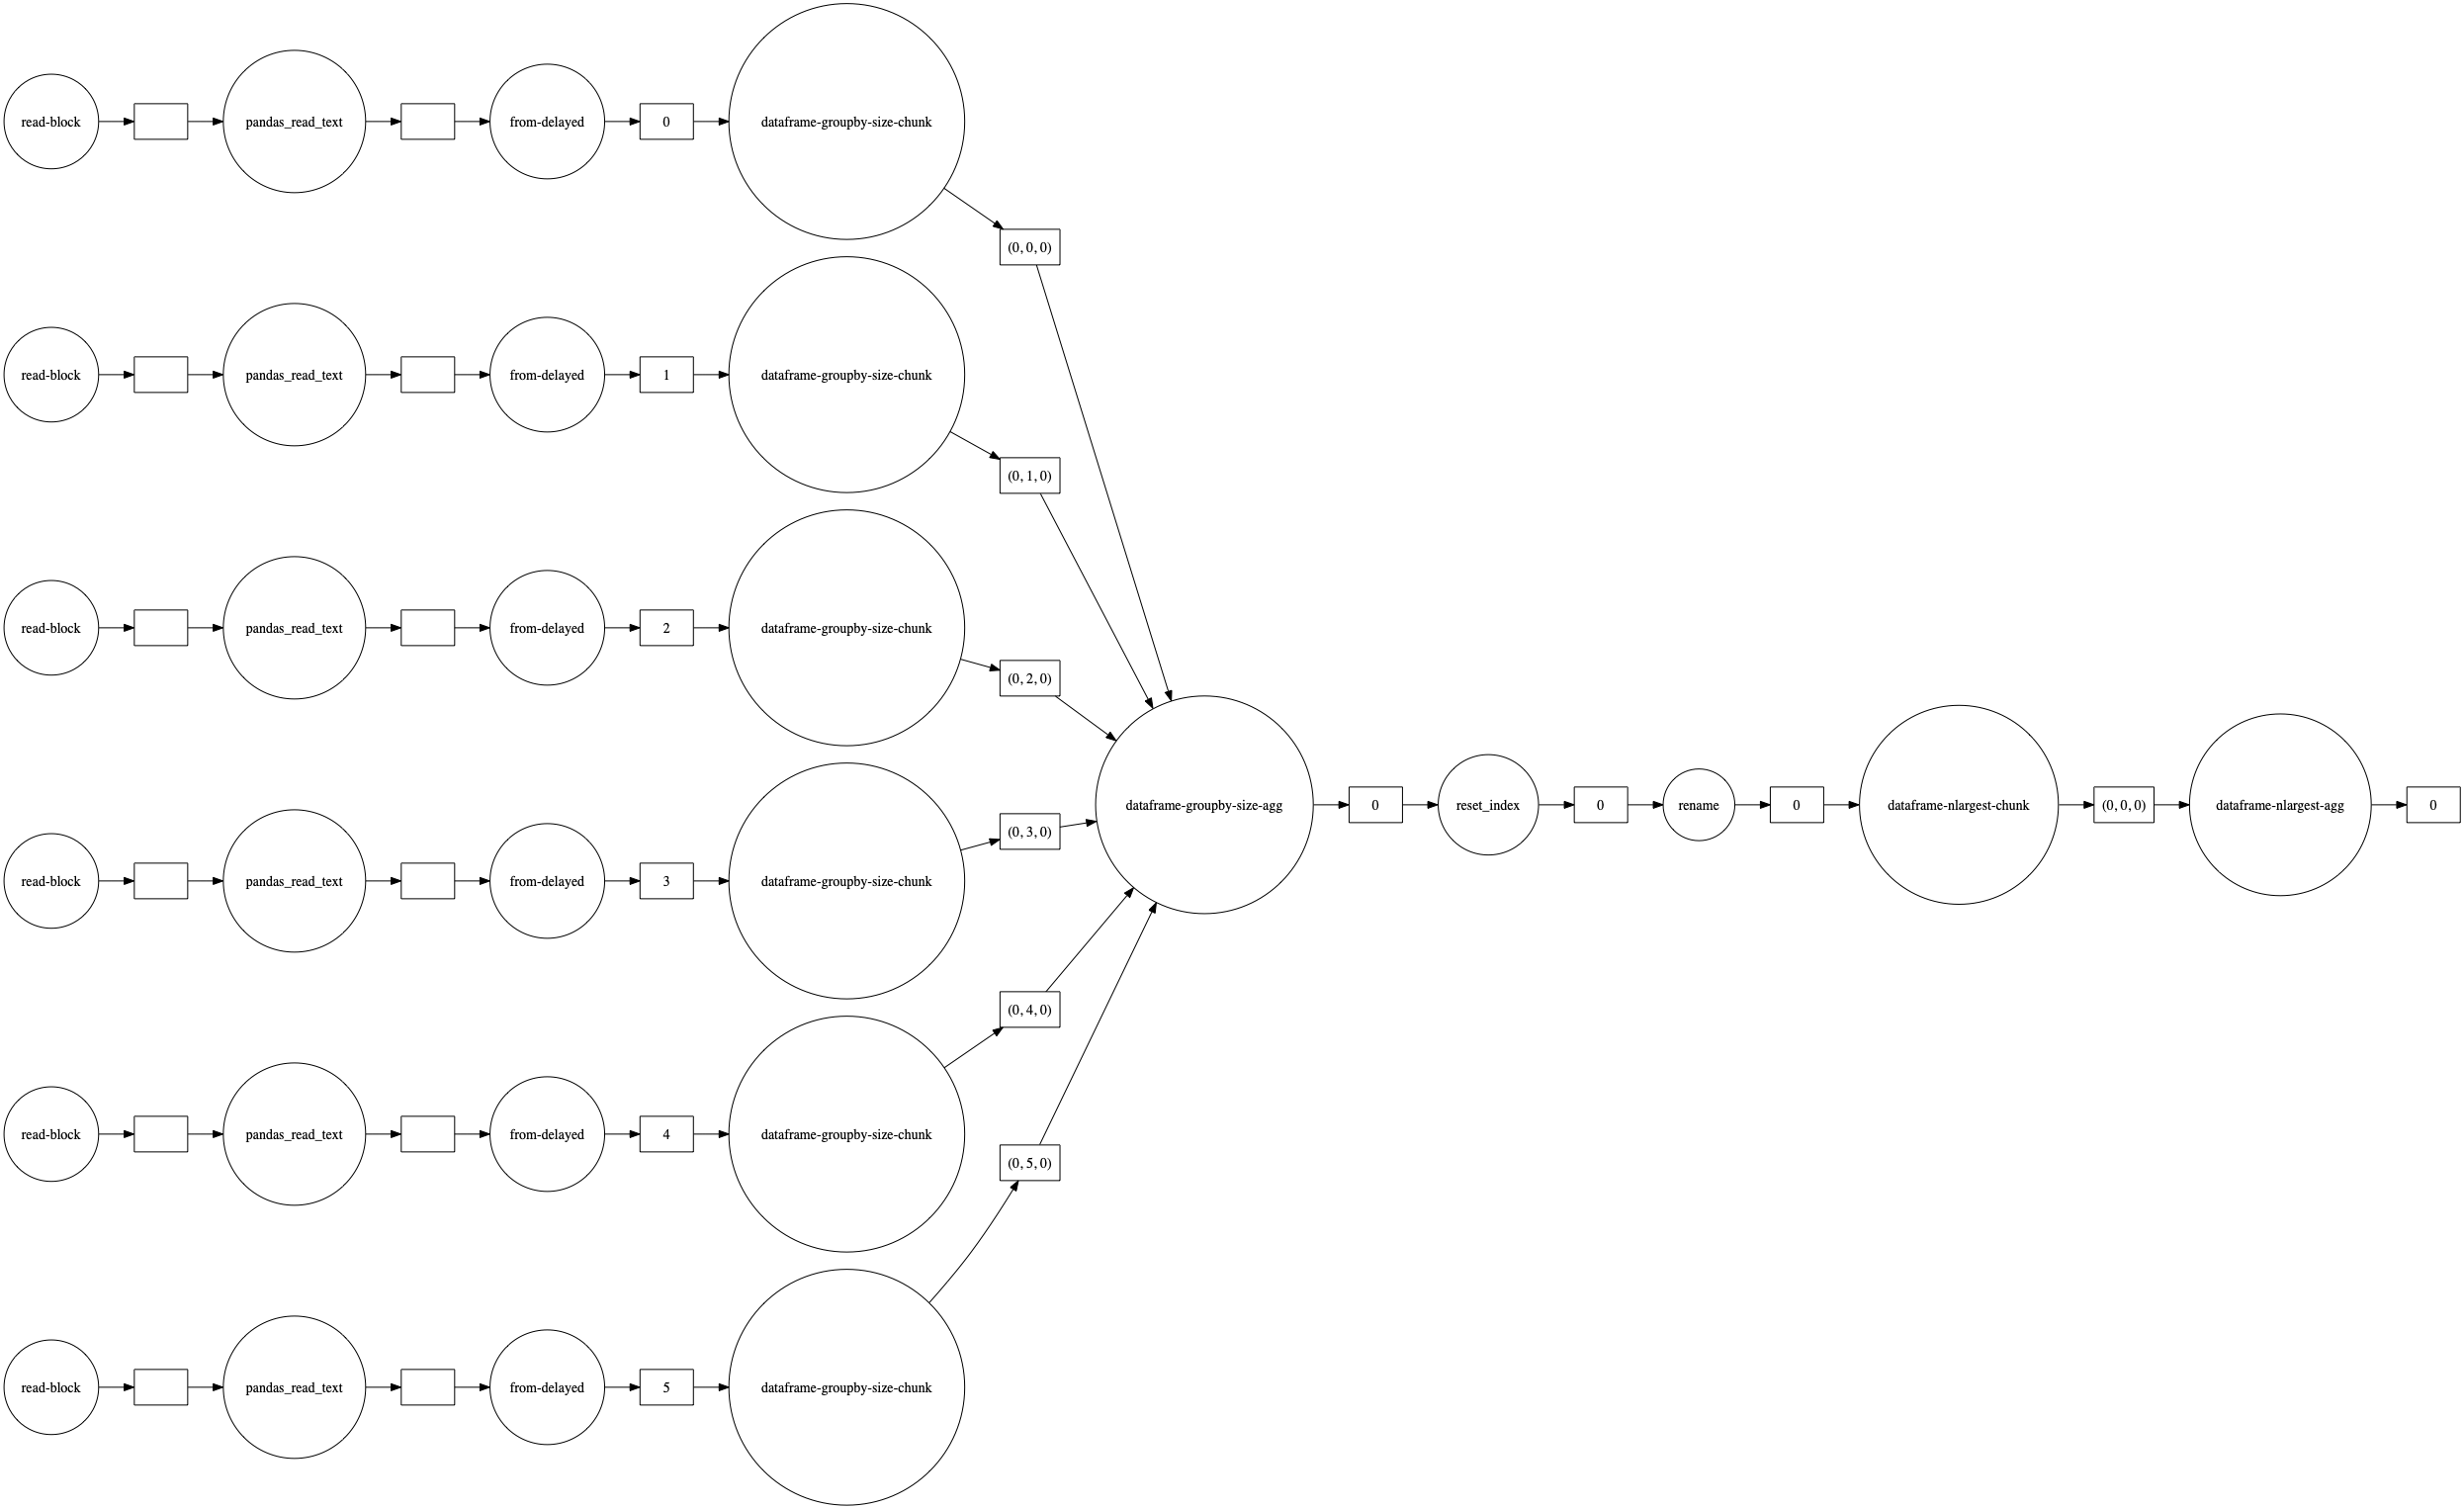

In [11]:
# Visualize the task graph
bor_count.visualize(rankdir = "LR")

In [12]:
# Compute the task graph
bor_count.compute()

,ARREST_BORO,Count
1,K,1334408


#### Example 4: Expand ARREST_DATE column to year, month, and day

`dask.dataframe` provides a few methods to apply custom functions to `dask.dataframe` easier. 

One of the method is `map_partition`, which apply function on each partition. 

In [13]:
# Define a custom function to separate date into year, month, day
def year_month_day(df):
    df["year"] = df.ARREST_DATE.dt.year
    df["month"] = df.ARREST_DATE.dt.month
    df["day"] = df.ARREST_DATE.dt.day
    return df

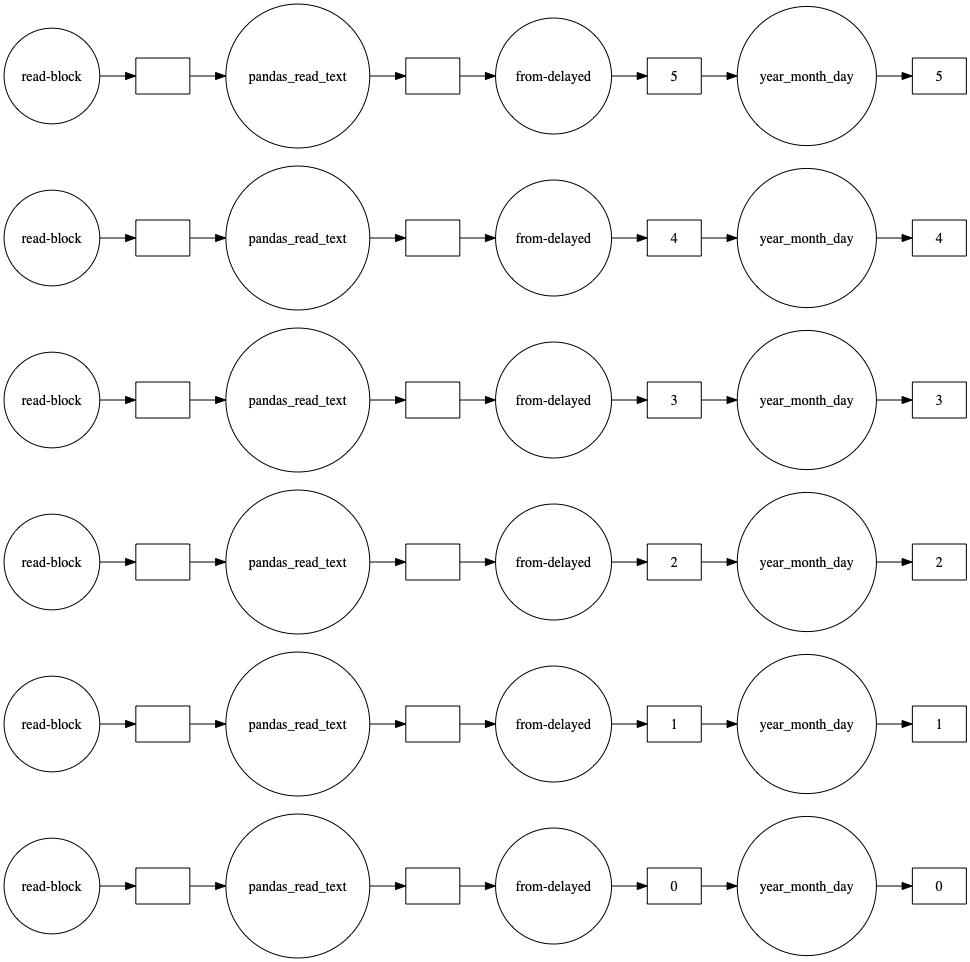

In [14]:
# Add function to map_partioions method and visualize task graph
NYC_date_separate = ddf.map_partitions(year_month_day)
NYC_date_separate.visualize(rankdir = "LR")

In [15]:
# Compute the funciton
NYC_date_separate.compute().head()

,ARREST_DATE,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,year,month,day
0,2017-12-31,Q,105,25-44,M,BLACK,40.735772,-73.715638,2017,12,31
1,2017-12-31,Q,114,25-44,M,ASIAN / PACIFIC ISLANDER,40.769437,-73.910241,2017,12,31
2,2017-12-31,K,73,18-24,M,BLACK,40.679525,-73.904572,2017,12,31
3,2017-12-31,M,18,25-44,M,WHITE,40.763523,-73.987074,2017,12,31
4,2017-12-31,M,18,45-64,M,BLACK,40.759768,-73.989811,2017,12,31


### 3. Speed Up Spatial Join with dask

Now, you have the basic understanding about `Dask`. Let's look how to speed up the spatial join operation with the help of it. 

In [16]:
# Import modules
import warnings
import pandas as pd
import numpy as np
import geopandas as gpd
import dask.dataframe as dd

from dask.distributed import Client
from shapely.geometry import Point

warnings.simplefilter(action = "ignore")
client = Client()
client

Client Scheduler: tcp://127.0.0.1:56778 Dashboard: http://127.0.0.1:56777/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


#### 3.1 Spatial join arrest records to NYC census tracts

In [17]:
# Load the dataset
NYC_arrest = dd.read_csv("data/NYC_historic_arrest/NYC_Historic_Arrest_Clean.csv")
print("There are {} partioins.".format(NYC_arrest.npartitions))

There are 6 partioins.


In [18]:
# Create a function to perform spatial join
def arrests_to_tract(arr_df, arr_lon, arr_lat):
    
    # Extract out longitude and latitude columns
    NYC_arrest_lat_lon = arr_df[[arr_lon, arr_lat]] 
    
    # Read the NYC census tracts into a geopandas dataframe
    NYC_tract = gpd.read_file("data/NYC_tract_2017/NYC_tract_2017.shp")
    
    # Covert to EPSG 4326
    if NYC_tract.crs.to_epsg ==4326:
        pass
    elif NYC_tract.crs.to_epsg != 4326:
        NYC_tract = NYC_tract.to_crs("EPSG:4326")
    
    # Using shapely class "Point" to create arrest points
    # Defines their coordinate systems and covert to geodataframe
    geometry = [Point(xy) for xy in zip(NYC_arrest_lat_lon[arr_lon], NYC_arrest_lat_lon[arr_lat])]
    arr_gdf = gpd.GeoDataFrame(NYC_arrest_lat_lon, crs = {'init':'epsg:4326'}, geometry = geometry)
    
    # Spatial join arrest points to enumeration units
    arr_enum_gdf = gpd.sjoin(arr_gdf, NYC_tract, op ="within")
    enumer_unit = arr_enum_gdf.TRACTCEFP
    
    return enumer_unit

Here we created a function with arguments to a dataframe that return a `pandas.series` containing the information about which census tract a record within. 

Now, we apply this function on each `dask.dataframe` partition using `map_partitions` method. Here is the syntax of this method:
```python
map_partiions(func, *args, **kwargs)
```
- `func`: Function applied to each partition. 

- `args`, `kwargs`: Arguments and keywords to pass to the function. In our case, the arguments would be **_Longitude_** and **_Latitude_** column. 

- `meta`: This is optional argument. However, this metadata is necessary for many algorithms in `dask.dataframe` to work. In our case, we specify the output in a `pandas.series` with the name **_In_Tract_**, and dtype **_np.unicode_**.

In [19]:
# Apply the function to each partition
# Each partition will append a new column identifing the census tract a record within
NYC_arrest["In_Tract"] = NYC_arrest.map_partitions(arrests_to_tract, "Longitude","Latitude", 
                                                   meta = ("In_Tract", np.unicode_))

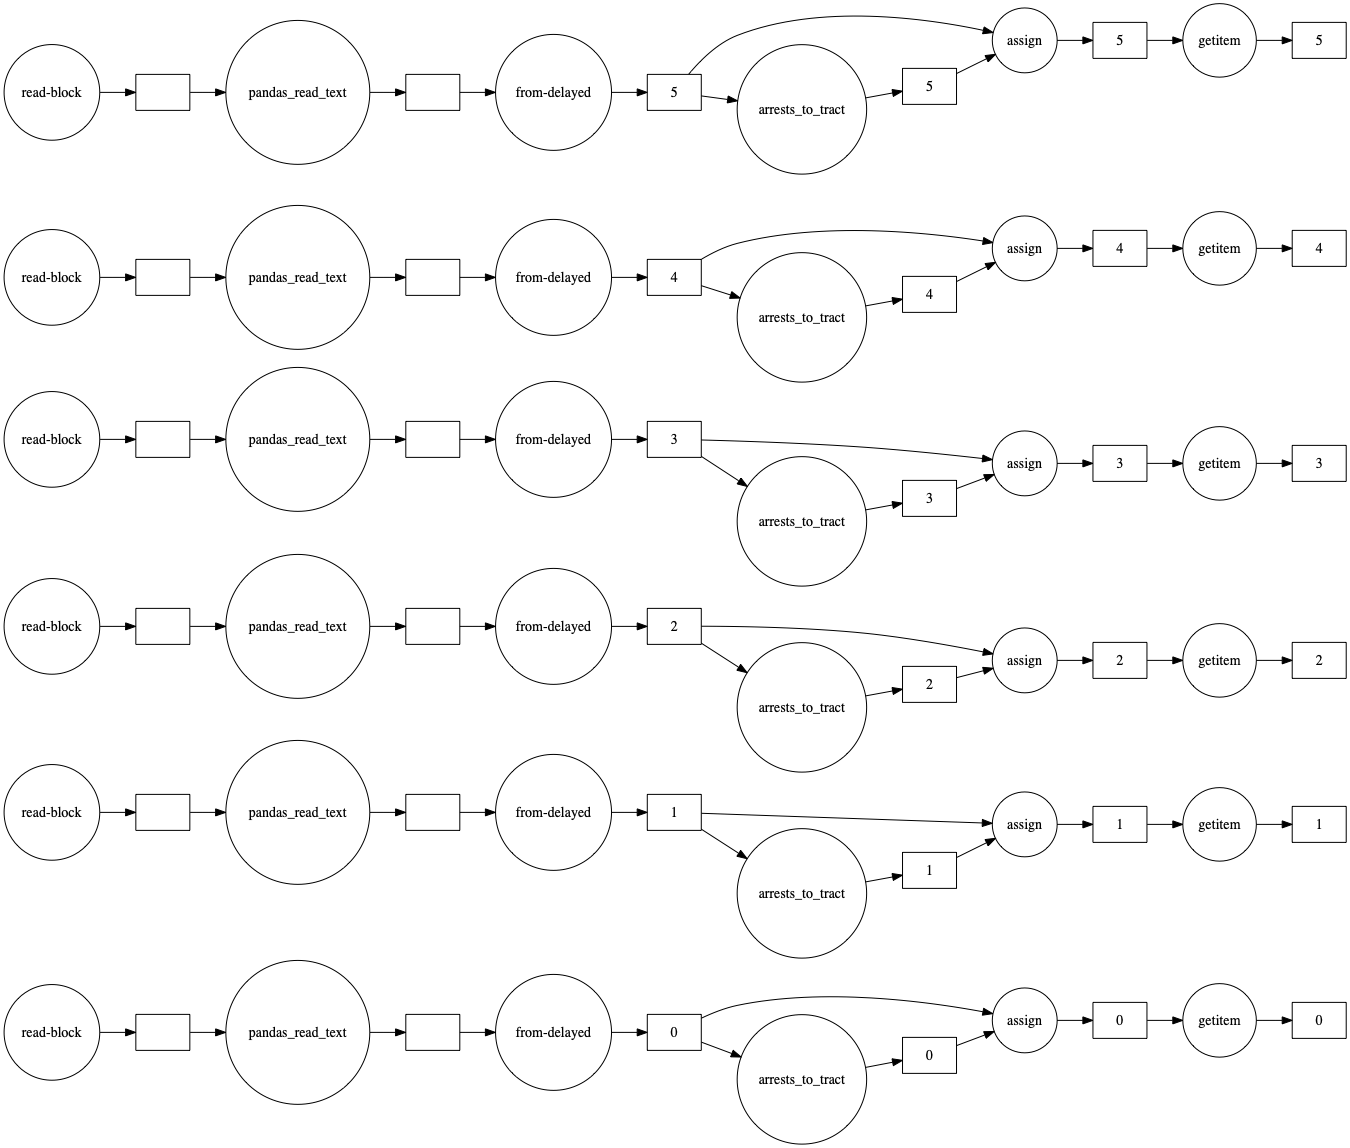

In [20]:
# Visualize the task graph
NYC_arrest["In_Tract"].visualize(rankdir = "LR")

Recall what we have discussed, if the computation result doesn't fit in memory, we can write the result to the more efficient format and read it. While the result we acquire will fit in memory, I would like to store it to the disk to simulate the situation you might encounter when you are actually working with "big data". 

To do so, we will use `to_parquet` method to store the  `dask.dataframe` to [Apache Parquet](https://en.wikipedia.org/wiki/Apache_Parquet), a columnar storage format for Hadoop ecosystem. It stores nested data structures in a flat columnar format. Compared to a traditional approach where data is store in row-oriented approach (such as CSV files), parquet is more efficient in terms of storage and performance. 

In [21]:
columns_list = ["ARREST_DATE", "ARREST_BORO", "ARREST_PRECINCT", 
                "AGE_GROUP", "PERP_SEX", "PERP_RACE", "In_Tract"]

In [22]:
%%time
NYC_arrest[columns_list].to_parquet("NYC_arrest.parquet")

CPU times: user 13.2 s, sys: 2.23 s, total: 15.4 s
Wall time: 3min 42s


#### 3.2 Count the number of arrest records in each census tract
We now have the information about where each record reside so we can count the number of records in each census tract.

In [23]:
# Read the parquet file into a dask dataframe
arrest = dd.read_parquet("NYC_arrest.parquet")
arrest

,ARREST_DATE,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,In_Tract
npartitions=6,,,,,,,
,object,object,int64,object,object,object,object
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [24]:
# Count the number of records in each census tract
count = arrest.groupby("In_Tract").size().reset_index().rename(columns = {"In_Tract":"TRACTCEFP",0:"Count"})

Since the map we are going to create is a choropleth map, we have to normalize underlying data to account for varying size of enumeration units. (Cartographic rule of [choropleth maps](https://doc.arcgis.com/en/insights/latest/create/choropleth-maps.htm)!!)

In [25]:
# Create a function to normalize the count value
def normalize(df):
    minimum = df.Count.min()
    diff = df.Count.max() - df.Count.min()
    return df.Count.apply(lambda x: (x - minimum) / diff)

In [26]:
# Lazy function for normalizing the counting
count["Normalized_Count"] = count.map_partitions(normalize, meta = ("Normalized_Count", np.float))

In [27]:
# Trigger the function
count_df = count.compute()

#### 3.3 Merge the count and normlize count values to the enumeration units

In [28]:
# Read the enumeration unit file
NYC_tract = gpd.read_file("data/NYC_tract_2017/NYC_tract_2017.shp")

In [29]:
# Merge to the enumeration units
count_in_unit = NYC_tract.merge(count_df, on="TRACTCEFP")
count_in_unit.head()

,STATEFP,COUNTYFP,TRACTCEFP,geometry,Count,Normalized_Count
0,36,005,005001600,"POLYGON ((-73.86246 40.81925, -73.86153 40.819...",1452,0.036287
1,36,005,005003800,"POLYGON ((-73.86575 40.82101, -73.86298 40.821...",368,0.009178
2,36,005,005004600,"POLYGON ((-73.87152 40.82471, -73.86950 40.824...",19547,0.488809
3,36,005,005007700,"POLYGON ((-73.90566 40.82156, -73.90490 40.821...",4880,0.122015
4,36,005,005011502,"POLYGON ((-73.88965 40.82120, -73.88930 40.821...",6357,0.158952


#### 3.4 Create a choropleth map
Let's create an interactive choropleth map using `Bokeh`. 

In [30]:
# Import modules
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool, GeoJSONDataSource, tiles

output_notebook()

Loading BokehJS ...

In [31]:
# 1. Conver the geodataframe to EPSG:3857 (Web mercator)
"""
This is because we are going to use tiled maps and
tiled maps are typically in EPSG:3857
"""
count_in_unit = count_in_unit.to_crs("EPSG:3857")

In [32]:
# 2. convert geodataframe to geojson representation
geosource = GeoJSONDataSource(geojson = count_in_unit.to_json())

In [33]:
# 3. Find the range of x and y
xrange = (min(count_in_unit.bounds[["minx", "maxx"]].values.flatten()),
          max(count_in_unit.bounds[["minx", "maxx"]].values.flatten()))
yrange = (min(count_in_unit.bounds[["miny", "maxy"]].values.flatten()),
          max(count_in_unit.bounds[["miny", "maxy"]].values.flatten()))

In [34]:
# 4. Add a hover tool
field_hover = HoverTool()
field_hover.tooltips = ("<div><b>CountyFIP</b>: @COUNTYFP</div>"
                        "<div><b>TractFIP</b>: @TRACTCEFP</div>"
                        "<div><b>Raw Count</b>: @Count{(0,0)}</div>" 
                        "<div><b>Normalized Count</b>: @Normalized_Count{(0.00)}</div>")
field_hover.point_policy = "follow_mouse"

`Bokeh`'s `LinearColorMapper` class is a useful tool to map values into a sequence of colors, think of it as equal-interval classification method. You can read more information [here](https://docs.bokeh.org/en/latest/docs/reference/models/mappers.html). 

In [35]:
# 5. Define the color mapper to map normalized count into a sequence of colors
from bokeh.models import LinearColorMapper

# Create the color mapper
color_mapper = LinearColorMapper(palette = ['#f3e79b', '#f8a07e', '#eb7f86', '#ce6693', '#a059a0'], 
                                 low = 0.05, high =0.95, low_color = '#F0F0F0', high_color = '#5c53a5')

In [36]:
# 8. Add the tile 
from bokeh.models import tiles

# Get the provider tile
tile = tiles.WMTSTileSource(url="https://api.mapbox.com/styles/v1/mapbox/dark-v10/tiles/512/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoibGluMDAyOTciLCJhIjoiY2ptaWEybm82MDJ2azNqbzF4Z2QxNHp0OSJ9.sviWrGp6eV8h8VIDvQmmTQ")

In [37]:
# Initialize a figure object
p = figure(title = "Number of Arrests in NYC from 2007-2018",
           plot_height = 700 , plot_width = 700, 
           x_range = xrange, y_range = yrange,
           toolbar_location = 'right',
           tools = "pan, wheel_zoom, zoom_in, zoom_out, box_zoom, reset")

# Style the title
p.title.text_font = 'times'
p.title.text_font_style = 'bold'
p.title.text_font_size = '14pt'
p.title.align = 'center'


# Deactivate grid line and axis
p.xgrid.visible = False 
p.ygrid.visible = False
p.axis.visible = False

# Add the tile
p.add_tile(tile)

# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,          
                   fill_color = {'field':'Normalized_Count', 'transform': color_mapper}, 
                   line_color = '#F0F0F0',
                   line_width = 0.3,
                   fill_alpha = 1)

# Add the hover tool
p.add_tools(field_hover)

show(p)

From the above example, you see how to implement `Dask` to perform the spatial join operation. You might feel the speed of using `Dask` wasn't different from using `Geopandas`'s `sjoin()` method. This is because the datasets are not "big" enough, they can easily fit in memory. Under this situation, it might be better to use `Geopandas` in terms of its simplicity. However, when the data is too large to fit in your memory, you should consider using `Dask` to help you perform spatial join in that `Geopandas` is not scallable and parallelizable.  

### 4. Extra: Geopandas and Spatial index
The following section provides an exmple on using `Geopandas` and **_Spatial Index_** to speed up common spatial operations, such as intersects, contains, within, and so on.  

This example is adapted from this [blogpost](https://github.com/gboeing/urban-data-science/blob/master/19-Spatial-Analysis-and-Cartography/rtree-spatial-indexing.ipynb).

#### 4.1 Understand spatial index
The term **_spatial index_** is originated from spatial database systems. It is a type of extended index that allows you to index a spatial column. In the context of database systems, an index is a data structure defined on columns in a database table to signigicantly speed up data retrieval operations. You can think of index as the contents page of a book that can help you fastly look up the topic you are interested in.

While there are various data structures of **_spatial index_**, the most popular one and widely used is a spatial index based on [R-tree](https://en.wikipedia.org/wiki/R-tree) data structure. 

The key idea behind the R-tree is to for a tree-like data structure where nearby objects are grouped together, and their geographical extent (minimum bounding box) is inserted into the data structure. This structure makes the query times for finding a single object from the data much faster, as the algorithm doesn't need to travek through all geometries in the data. Below is the example of R-tree.

<img src="https://github.com/Ray800413/Spatial_Join_with_Dask/blob/master/image/rtree1.png?raw=true" style="width: 500px;">

#### 4.2 Example: Find the points that intersects with a given polygon
We continue using the above two datasets as our source data, and the task here is to find the arrests occured in a given census tract.

In [38]:
# Import modules
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
from shapely.geometry import Point

In [39]:
# Read the datasets
NYC_arrest = pd.read_csv("data/NYC_historic_arrest/NYC_Historic_Arrest_Clean.csv")
NYC_tract = gpd.read_file("data/NYC_tract_2017/NYC_tract_2017.shp")

In [40]:
# Define a function to convert a dataframe to a geodataframe
def arrest_to_gdf(arr_df, arr_lon, arr_lat):
    
    NYC_arrest = arr_df.copy()
    
    # Using shapely class "Point" to create arrest points
    # Defines their coordinate systems and covert to geodataframe
    geometry = [Point(xy) for xy in zip(NYC_arrest[arr_lon], NYC_arrest[arr_lat])]
    arr_gdf = gpd.GeoDataFrame(NYC_arrest, crs = {'init':'epsg:4326'}, geometry = geometry)
    
    # Drop the longitude and latitude column
    arr_gdf.drop(columns = [arr_lon, arr_lat], inplace = True)
    
    return arr_gdf

In [41]:
# Convert NYC_arrest to geodataframe
NYC_arrest_gdf = arrest_to_gdf(NYC_arrest, "Longitude", "Latitude")
NYC_arrest_gdf.head()

,ARREST_DATE,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,geometry
0,12/31/2017,Q,105,25-44,M,BLACK,POINT (-73.71564 40.73577)
1,12/31/2017,Q,114,25-44,M,ASIAN / PACIFIC ISLANDER,POINT (-73.91024 40.76944)
2,12/31/2017,K,73,18-24,M,BLACK,POINT (-73.90457 40.67952)
3,12/31/2017,M,18,25-44,M,WHITE,POINT (-73.98707 40.76352)
4,12/31/2017,M,18,45-64,M,BLACK,POINT (-73.98981 40.75977)


Building a spatial index on `Geopandas` dataframe is easy by calling the `sindex` method. 

In [42]:
# Build spatial index for NYC_arrest_gdf
arrest_sindex = NYC_arrest_gdf.sindex

# See what it is
# This object contains the geometries of NYC arrest in an R-tree data strucutre
arrest_sindex

rtree.index.Index(bounds=[-74.25493873599999, 40.49890536300006, -73.70049339099995, 40.915047885000035], size=4791212)

We can see how many leaves this spatial index have by using `leaves()` function.

In [43]:
# Get the numer of leaves
leaves = len(arrest_sindex.leaves())
print("Number of leaves: {}".format(leaves))

Number of leaves: 68446


Now, let's see the number of geometris from five leaves. 

In [44]:
# Get the number of geometries in leaves and their bounding box coordinates
i = 0
for group in arrest_sindex.leaves():
    if i <= 5:
        group_idx, geometry, bbx = group
        print("Group {} contains {} geometries, bounding box: {}".format(group_idx, len(geometry), bbx))
    i+=1

Group 3178 contains 70 geometries, bounding box: [-73.95820727299997, 40.640590848000045, -73.95571759899997, 40.64085528000004]
Group 57697 contains 70 geometries, bounding box: [-73.96573819199995, 40.640247973000044, -73.960502492, 40.64122243000002]
Group 57935 contains 70 geometries, bounding box: [-73.95820727299997, 40.64085528000004, -73.95820727299997, 40.64085528000004]
Group 15228 contains 70 geometries, bounding box: [-73.957241647, 40.640590848000045, -73.95571759899997, 40.64128004900005]
Group 14991 contains 70 geometries, bounding box: [-73.960502492, 40.64085528000004, -73.95820727299997, 40.64121546400003]
Group 29641 contains 70 geometries, bounding box: [-73.957241647, 40.640783561000035, -73.95533157399994, 40.64130434400005]


For conducting fast spatial join, we can utilize the spatial index of arrests, and compare the geometry of census tracts to the bounding boxes of points inside the R-tree spatial index. The point into polygon spatial join is conducted in two steps:
- First, we compare the bounding box of the polygon to the spatial index of the points. This gives us **_candidate points_** that are likely to be within the polygon. 
- Second, we go through the candidate points and make a normal spatial intersection that gives us the **_accurate points_**. 

To make it more clearly, let's start with a single polygon:

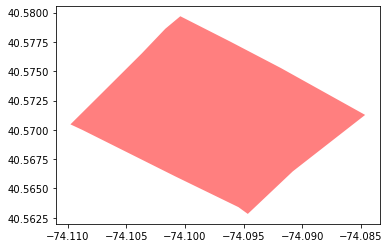

In [45]:
# Select a tract
poly = NYC_tract.loc[NYC_tract["TRACTCEFP"]=="085011202"]
poly.plot(color = "red", alpha = 0.5)

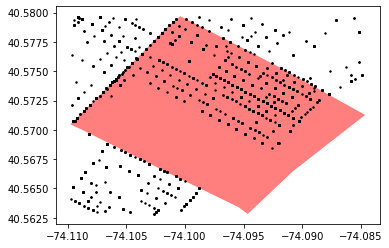

In [46]:
# Get the bounding box coordinates of the polygon as a list
poly_bound = poly.geometry.bounds.values[0].tolist()

# Get the indices of points that are inside the bounding box of the polygon
can_points_idx = list(arrest_sindex.intersection(poly_bound))
can_points = NYC_arrest_gdf.loc[can_points_idx]

# Plot them out
ax = poly.plot(color = "red", alpha = 0.5)
ax = can_points.plot(ax = ax, color = "black", markersize =2)

The following line of code will return a list of indexs of points that are contained within the bounding box of the polygon.
```python
list[arrest_sindex.intersection(poly_bound)]
``` 
The `index.intersection()` method is inherited from the Python [Rtree](https://toblerity.org/rtree/index.html) module. Note the the bounding box we pass to this method, the coordinates must be in the form `[xmin, ymin, ..., kmin, xmax, ymax, ..., kmax]`.

The reason we have to cast the indexes into the list is that `loc[]` method only takes a list or array of indexes(labels) as input. 


Now, you can see the points that intersect with the bounding box of the polygon. Next, let's do the normal intersection to select the actual points that intersect with the polygon. 

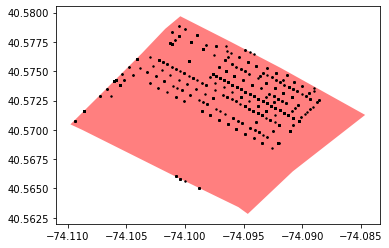

In [47]:
# Find the points that actually intersect with the polygon geometry
fin_points = can_points.loc[can_points.intersects(poly.geometry.values[0])]

# Plot them out
ax = poly.plot(color = "red", alpha = 0.5)
ax = fin_points.plot(ax = ax, color = "black", markersize =2) 

The following line of code will return a series of boolean that identifies the points that actually intersect with the Polygon.
```python
can_points.intersects(poly.geometry.values[0])
```
Since the `intersects()` method is inherited from the Python [Shapely](https://shapely.readthedocs.io/en/latest/index.html) module, the object passed to this method should be a shapely object. This is why we use `poly.geometry.values[0]` as this returns a shapely object to us. 

From this simple example, you now understand how can spatial index help to speed up spatial operation like intersects. However, this method will not always work faster than traditional intersects method because the spatial index building time. You should consider this method only when you want to perform spatial operations on two large datasets. 

### 5. Conclusion
In this tutorial, we walked through the introduction of Python `Dask` and see how it can improve the speed of the spatial join operation. You also learn how to use `Geopandas` with **_Spatial Index_** to speed up the common spatial operations. Since the datasets used for this tutorial are not "big" enough, the performance of the above spatial operations seem not to improve a lot using `Dask` and **_Spatial Index_**. However, you should keep them in mind and they will come in handy when the time you really work with "big" data.   

Developers working at Anaconda are carrying out a project called `Dask-Geopandas`, which basically incorporate `Cython` and `Dask` into `Geopandas` to speed up geospatial data analysis. However, due to some technical and financial reasons, the project is currently suspended. You can stay tuned with their [github repo](https://github.com/jsignell/dask-geopandas) to know when it is ready to use. 

Thank you for reading this tutorial. If you have trouble reproducing the steps, or if you find any problem, let me know by sending email to this address lin00297@umn.edu